ARIMA Conceptually: !https://www.youtube.com/watch?v=8t11SmVD8dU&list=PLqYFiz7NM_SMC4ZgXplbreXlRY4Jf4zBP&index=4

Python Walkthrough: https://www.youtube.com/watch?v=8FCDpFhd1zk&list=PLqYFiz7NM_SMC4ZgXplbreXlRY4Jf4zBP&index=6


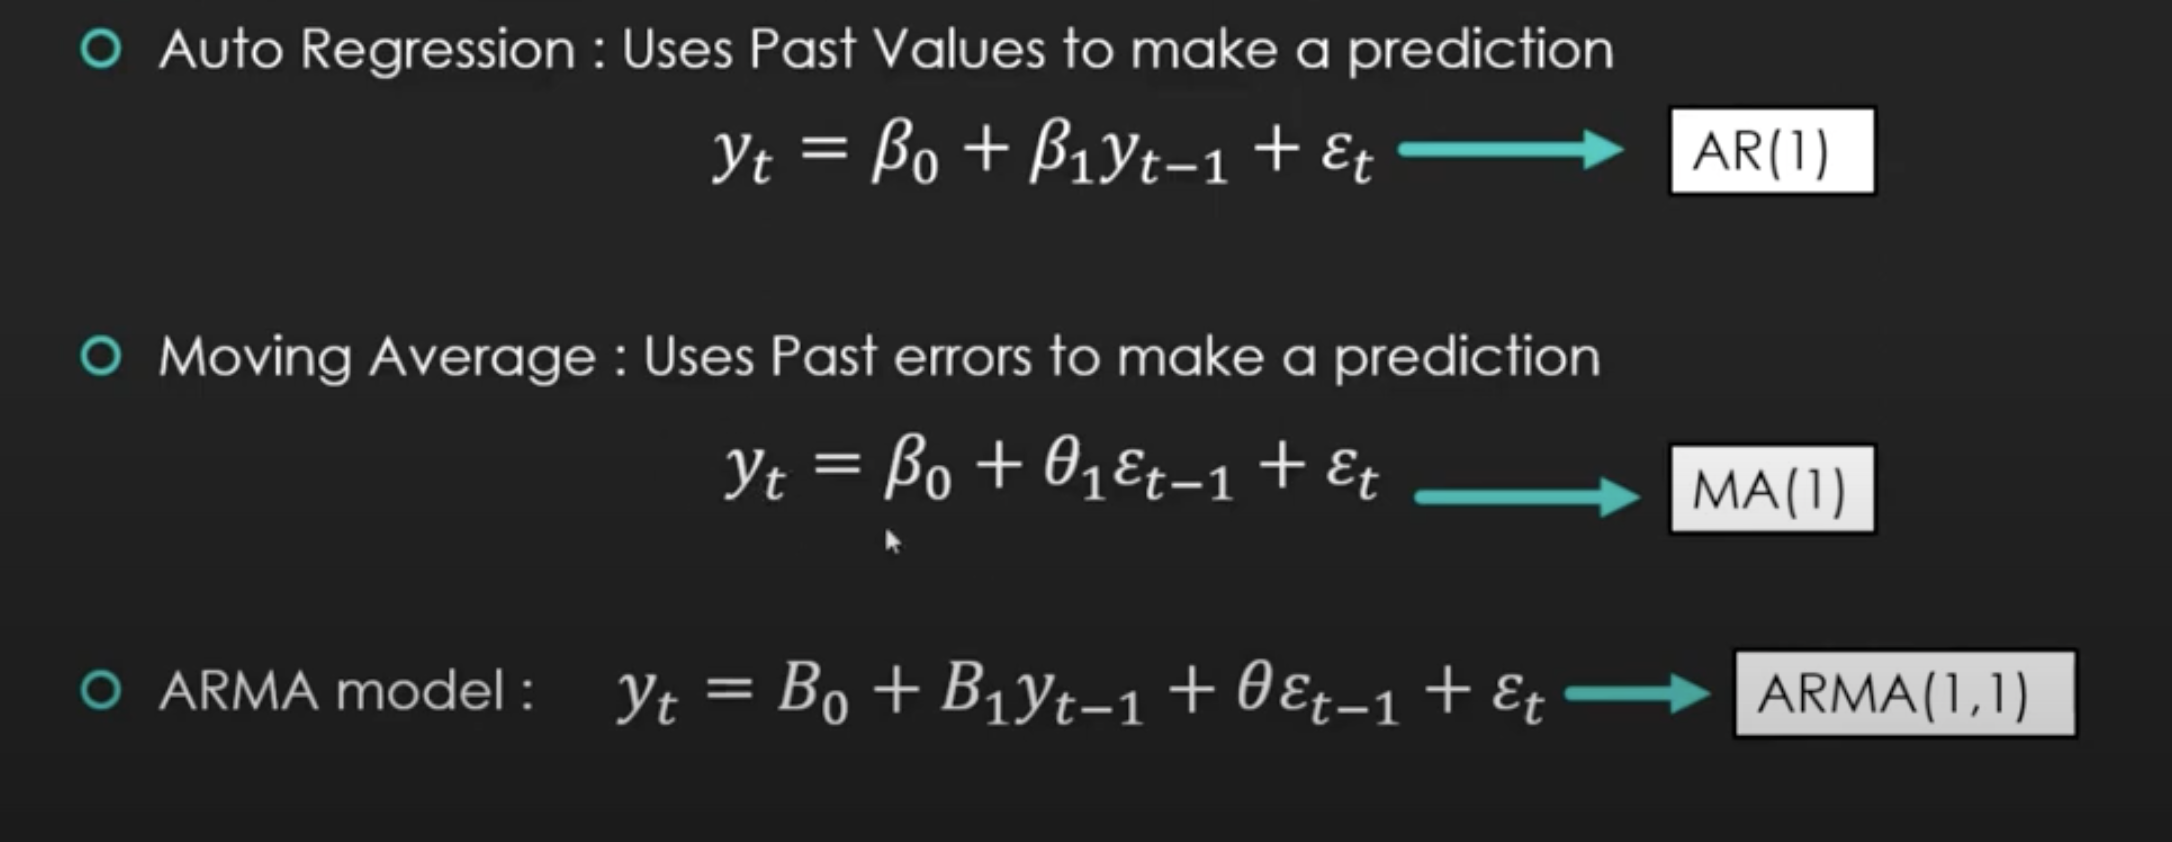

**Good Date Code I liked**

In [ ]:
# dates = datetime.strptime('2018-01-01','%Y-%m-%d') - timedelta(days = len(close_dataframe.index))
# dates

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00


In [ ]:
!pip install gdeltdoc

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00


In [ ]:
import pandas              as pd
import numpy               as np
from   pmdarima            import auto_arima
from   sklearn.metrics     import mean_squared_error
from   math                import sqrt
import re

import matplotlib.pyplot as plt
import plotly.express    as px
import seaborn           as sns
from   zipfile           import ZipFile
from   datetime          import datetime, timedelta
import random

from pmdarima.arima              import ADFTest
from statsmodels.tsa.stattools   import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection     import train_test_split
import scipy.integrate as integrate


import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Bidirectional, LSTM, Lambda, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing   import StandardScaler


from gdeltdoc import GdeltDoc, Filters, near, repeat
from datetime import datetime
from dateutil.relativedelta import relativedelta

from bs4            import BeautifulSoup
from urllib.parse   import urlparse
from urllib.request import urlopen
from urllib.error   import HTTPError

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle          # Making New File Directory
!cp kaggle.json ~/.kaggle/ #New File Path
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

In [ ]:
! kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 44.4MB/s]


**Open Files**

In [ ]:
# class Preprocess:

#   def __init__(self, zip_file):
#     self.zip_file = zip_file



#     self._load_zip(self.zip_file)


#   def _load_zip(self, zip_file):


with ZipFile('stock-time-series-20050101-to-20171231.zip') as zip:
  data        = {}
  close_price = {}
  company_names = []
  for company in zip.namelist():
    pattern_company  = re.compile(r'^\w+(?=_\w+)', flags = re.IGNORECASE)
    company_acryonym = pattern_company.findall(company)[0]
    with zip.open(company) as csv:
      data[company_acryonym] = pd.read_csv(csv, parse_dates = True)
      company_names.append(company_acryonym)
      close_price[company_acryonym] = data[company_acryonym]['Close']


company_names           = np.unique(np.array(company_names))
company_names           = pd.Series(company_names)
close_dataframe         = pd.concat([pd.DataFrame(close_price[company]) \
                           for company in close_price],axis = 1)
close_dataframe.columns = company_names

all_stocks_summed       = close_dataframe['all_stocks']
close_dataframe         = close_dataframe.drop(columns = ['all_stocks'])
close_dataframe         = close_dataframe.dropna()
dates                   = data['AAPL']['Date']
close_dataframe.index   = dates
close_dataframe.index   = pd.to_datetime(close_dataframe.index, format = '%Y-%m-%d')

# Create new DataFrame with complete date range
complete_date_range = pd.date_range(start=close_dataframe.index[0], end=close_dataframe.index[-1])
complete_dataframe = pd.DataFrame(index=complete_date_range)

# Merge original and complete DataFrames
close_dataframe = pd.merge(close_dataframe, complete_dataframe, how='outer', left_index=True, right_index=True)


**Make Sure Data Has Equal Time Intervals**

In [ ]:
def impute_missing(close_dataframe = close_dataframe):

  close_dataframe.index = pd.to_datetime(close_dataframe.index)

  # close_dataframe     = close_dataframe.assign(AAPL=close_dataframe['AAPL'].interpolate(method='time'))
  close_dataframe = close_dataframe.interpolate(method='time')
  close_datafrmae = close_dataframe.round(0)


  return close_dataframe



def remove_trailing_zeros(df):
    return df.applymap(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)


# Impute Missing Values
close_dataframe = impute_missing()

# Apply the function to your DataFrame
close_dataframe = remove_trailing_zeros(close_dataframe)

# Convert to Days
close_dataframe.index   = (close_dataframe.index - close_dataframe.index[0]).days
close_dataframe         = close_dataframe.astype(float)
close_dataframe

,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
0,40.91,10.68,47.58,52.58,70.44,57.80,17.45,59.08,24.40,35.37,...,26.84,10.74,23.78,58.78,45.99,61.73,56.53,30.38,46.23,58.47
1,40.97,10.71,47.25,51.95,71.17,59.27,17.85,58.91,23.99,35.32,...,26.97,10.69,24.55,58.89,46.50,61.88,56.19,31.27,46.32,58.57
2,41.53,10.63,47.65,52.50,70.33,59.27,18.35,58.19,24.41,35.23,...,26.99,10.76,24.58,58.70,46.95,61.69,55.98,31.63,45.69,58.28
3,43.21,10.90,47.87,52.68,69.35,60.45,18.77,59.25,24.74,35.47,...,26.91,10.72,24.85,58.64,47.21,62.90,56.16,31.35,45.88,59.43
4,43.28,10.89,47.61,53.12,69.16,60.82,18.87,59.15,24.83,35.44,...,26.89,10.77,24.85,58.79,47.22,62.40,56.37,31.39,45.82,59.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374,70.29,171.68,1174.66,98.68,295.08,155.47,38.50,124.94,108.89,17.49,...,85.43,63.66,36.16,92.02,134.40,220.42,127.25,53.14,98.17,83.94
4375,69.86,170.57,1176.76,98.74,295.10,155.75,38.48,124.98,108.67,17.50,...,85.40,63.29,36.14,92.13,134.39,220.00,127.23,53.19,98.21,83.97
4376,70.06,170.60,1182.26,98.57,295.36,156.44,38.56,125.98,108.12,17.43,...,85.71,63.65,36.21,92.48,134.78,219.60,127.14,53.22,99.16,83.98
4377,69.82,171.08,1186.10,99.13,295.62,157.52,38.59,125.55,107.64,17.38,...,85.72,62.95,36.33,92.10,134.77,220.42,127.58,53.28,99.26,83.90


**Train-Test Split**

In [ ]:
def model_datasets():

  train_split = round(4*len(close_dataframe.index)/5)
  train_data  = close_dataframe[:train_split]
  test_data   = close_dataframe[train_split:]

  return train_data, test_data


train_data, test_data = model_datasets()

training_dates          = list(close_dataframe.index[:len(train_data.index)])
test_dates              = list(close_dataframe.index[len(train_data.index):])

train_data.index      = training_dates
test_data.index       = test_dates

**Investigating First Order Derivitive of Data**
1. Data was not being forecasted well so looking into different data transformations

In [ ]:
def differentiate_data(data):

  new_df   = pd.DataFrame()
  for company in data.columns:
    new_df[company] = np.gradient(np.array(data[company]))

  return new_df

train_diff     = differentiate_data(train_data)
test_diff      = differentiate_data(test_data)

train_2nd_diff = differentiate_data(train_diff)
test_2nd_diff  = differentiate_data(test_diff)

In [ ]:
# use standard scaler to see if outcome changes

def scale_data(train_data, scale = False):

  scaler = StandardScaler()

  if scale:
    train_data = pd.DataFrame(scaler.fit_transform(train_data), columns = train_data.columns)

  return train_data, scaler

train_data, scaler               = scale_data(train_data)
train_diff, diff_scaler          = scale_data(train_diff)
train_2nd_diff, diff2_scaler = scale_data(train_2nd_diff)


# Section 2: Arima Modeling

---



**Arima Model Check**

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


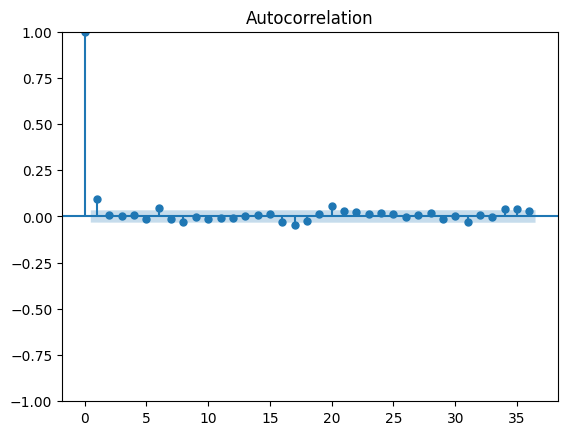

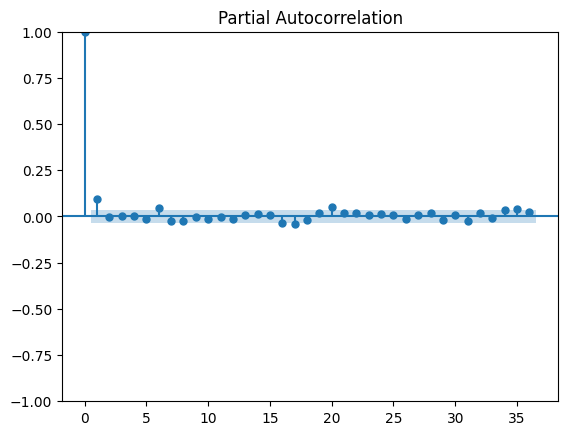

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original  = plot_acf(train_data['AAPL'].diff().dropna())

pacf_original = plot_pacf(train_data['AAPL'].diff().dropna())

In [ ]:
import warnings
warnings.filterwarnings('ignore')

stepwise_fit = auto_arima(train_data['AAPL'], trace = True, suppress_warnings = True, seasonal = False)
stepwise_fit.summary()

**Arima Tests**

In [ ]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train_data['AAPL'])

In [ ]:
def ad_test(column_name):
  test = adfuller(close_dataframe[column_name].diff().dropna())
  print('ADF: ', test[0])
  print('P-Value: ', test[1])
  return

ad_test('AAPL')

In [ ]:
models    = {}
# for company in train_data.columns:
#   models[company] =
apple_model = ARIMA(train_data['AAPL'], order = (2, 1, 2))
apple_model = apple_model.fit()
apple_model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                 3503
Model:                 ARIMA(2, 1, 2)   Log Likelihood                8477.023
Date:                Sun, 30 Jul 2023   AIC                         -16944.047
Time:                        14:22:43   BIC                         -16913.242
Sample:                             0   HQIC                        -16933.053
                               - 3503                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0469      0.008      5.518      0.000       0.030       0.064
ar.L2          0.0020      0.168      0.012      0.991      -0.328       0.332
ma.L1          0.0473      0.008      6.157      0.000       0.032       0.062
ma.L2          0.0017      0.170      0.010      0.992      -0.331       0.335
sigma2         0.0005   3.55e-06    130.307      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             57927.77
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               8.12   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.08e+17. Standard errors may be unstable.
"""

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(-200.0, 0, '−200'),
  Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000')])

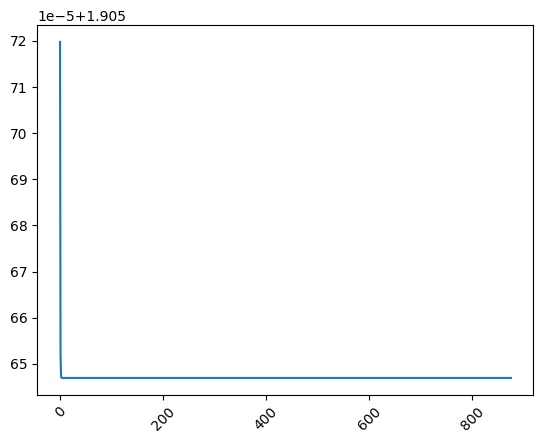

In [ ]:
start = len(train_data.index)
days  = len(test_data.index) -1
end   = len(train_data.index) + days
# apple_forecast        = apple_model.predict(start = start, end = end, typ = 'levels', dynamic = False)
apple_forecast          = apple_model.forecast(days +1)
apple_forecast.columns  = ['Forecast']
apple_forecast.index    = test_data.index
apple_forecast.plot()
plt.xticks(rotation = 45)

In [ ]:
plt.plot(apple_forecast.index, apple_forecast, label = 'Prediction')
plt.plot(test_data.index, test_data['AAPL'], label = 'AAPL Stock Price')
plt.legend()
plt.xticks(rotation = 45)

Trying to Fix Linearity Prediction: https://stackoverflow.com/questions/57080071/arima-model-producing-a-straight-line-prediction

# Section 3: Nueral Network Section

---





**Batching The Data Set**

In [ ]:
window_size  = 120
batch_size   = 32
buffer_size  = 10

def windowed_dataset(series, window_size = window_size, batch_size = batch_size, buffer_size = buffer_size, option = 'train'):

  # Convert list into tensor
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Creates Windows of Data [1, 2 ,3] , [2, 3, 4], etc.
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flattens Windows into one list [1, 2, 3, 2, 3, 4, 3, 4, 5]
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

  # Creates Shuffled Lists of Size 10 that are then mapped to ([1, 2, 3] [4]), ([2, 3, 4] [5]) (Train/Target Setup)
  dataset = dataset.shuffle(buffer_size = buffer_size).map(lambda window: (window[:-1], window[-1:]))



  if option == 'train':
    # Loads 2 and prefetches another set for computation reasons (parallel computing)
    dataset = dataset.batch(batch_size).prefetch(1)
  else:
    pass


  return dataset


train_batched          = windowed_dataset(train_data['AAPL']) # normal data

train_diff_batched     = windowed_dataset(train_diff['AAPL'])

train_2nd_diff_batched = windowed_dataset(train_2nd_diff['AAPL'])

In [ ]:
def build_model(node_size = 512):
    model   = Sequential([
              Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
              # Bidirectional(LSTM(32, return_sequences = True)),
              Bidirectional(LSTM(32)),
              Dense(node_size, activation = 'relu'),
              # Dense(node_size, activation = 'relu'),
              Dropout(0.25),
              Dense(node_size/2, activation = 'relu'),
              Dense(node_size/4, activation = 'relu'),
              Dense(1,  activation = 'relu')
          ])


    learning_rate = 0.000001
    AdamOpt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'mse', metrics = ['mse'], optimizer = AdamOpt)

    return model


model = build_model(node_size = 64)
model.build()
model.summary()

def fit_model(data, epochs = 7, verbose = 1, callbacks = None):

  history = model.fit(data, epochs = epochs, verbose = 2)

  return history

history        = fit_model(train_diff_batched)

# history        = fit_model(train_diff_batched)
training_mae   = history.history['mse']

**Second Derivitive Model**

In [ ]:
def build_secdiv_model():
  second_div_model = build_model(node_size = 64)
  second_div_model.build()
  second_div_model.summary()

  second_div_history     = fit_model(train_2nd_diff_batched)
  second_div_mae         = second_div_history.history['mse']

  return second_div_model, second_div_history, second_div_mae

second_div_model, second_div_history, second_div_mae = build_secdiv_model()


**Moving Forecast**

In [ ]:
def forecast_stocks(company_name, test_data = test_data, train_data = train_data, window_size = window_size):

  train_length     = len(train_data.index)
  forecast         = np.array((train_data[company_name][train_length - window_size:])) # first n days

  for day in range(len(test_data.index)):
    window_data      = forecast[day:window_size + day][np.newaxis]
    prediction       = model.predict(window_data)
    forecast         = np.append(forecast, prediction[0])


  return forecast

# forecast = forecast_stocks('AAPL')

forecast_1st_div = forecast_stocks('AAPL', test_data = test_diff, train_data = train_diff) # forecast for differnetiated values
forecast_sec_div = forecast_stocks('AAPL', test_data = test_2nd_diff, train_data = train_2nd_diff)

**Forecasted Results**

In [ ]:
def forecast_results(forecast_data, scaler, integration = True, scaling = False):

  forecasted_results    = np.empty_like(forecast_data) # creates an empty matrix with the same properties
  forecasted_results[0] = train_data['AAPL'][len(train_data.index)-1]      #

  if scaling:
    forecast_data = np.repeat(forecast_data[:, np.newaxis], train_data.shape[1], axis = -1)
    forecast_data = scaler.inverse_transform(forecast_data)[:,0]

  if integration:
    for index in range(1, len(forecasted_results)):
        delta_t = 1

        integrated_value = np.trapz([forecast_data[index], forecast_data[index-1]])
        forecasted_results[index] = integrated_value + forecasted_results[index-1]
  else:
    for index in range(1, len(forecasted_results)):
        forecasted_results[index] = np.cumsum(forecasted_results[index - 1]) + forecasted_results[index]

  return forecasted_results

# forecasted_results = forecast_results(forecast, scaler, integration = False)

forecasted_1st_div = forecast_results(forecast_1st_div,diff_scaler)
forecasted_2nd_div = forecast_results(forecast_sec_div, diff2_scaler)

**Recovered Array**

In [ ]:
# recovered_array = np.cumsum(forecast)

# print("Recovered array: ", recovered_array)

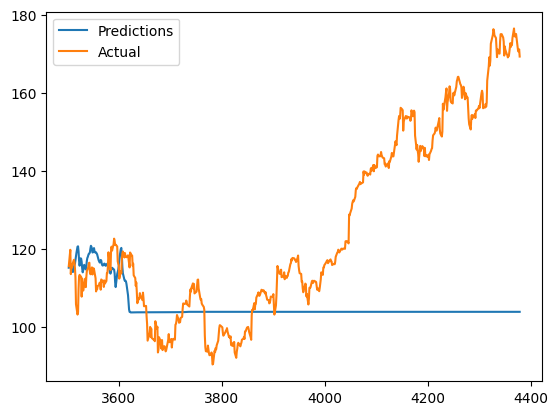

In [ ]:
def plot_data(forecasted_test):
  plt.plot(test_data.index, forecasted_test[:len(test_data['AAPL'])], label = 'Predictions')
  plt.plot(test_data.index, test_data['AAPL'], label = 'Actual')
  # plt.plot(train_data.index, train_data['AAPL'], label = 'Train')
  plt.legend()

  return

plot_data(forecasted_1st_div)

# plot_data(forecasted_2nd_div)

In [ ]:
plt.plot(test_data.index, forecast[window_size -1:len(test_data.index)+ window_size], label = 'Predictions')
plt.plot(test_data.index, test_data['AAPL'], label = 'Actual')
plt.plot(train_data.index, train_data['AAPL'], label = 'Train')
plt.legend()

# Section 4: NLP and LSTM Nueral Network

In [ ]:
#GDelt Doesn't Have up to date stock articles...
class Articles:

  def __init__(self, keyword = None, start_date = datetime.now() -  relativedelta(years=1),
               end_date = datetime.now().strftime('%Y-%m-%d'), num_records = 250, country = ["UK", "US"],
               theme = "GENERAL_HEALTH", repeat = repeat(5, "planet")):

    self.start_date  = start_date.strftime('%Y-%m-%d')
    self.end_date    = end_date
    self.num_records = num_records
    self.keyword     = keyword
    self.country     = country
    self.theme       = theme
    self.repeat      = repeat



  def pull_articles(self):

    if self.keyword is not None:
      f = Filters(
          start_date  = self.start_date,
          end_date    = self.end_date,
          num_records = self.num_records,
          keyword     = self.keyword,
          # domain = ["bbc.co.uk", "nytimes.com"],
          country     = self.country,
          theme       = self.theme,
          repeat      = self.repeat

      )

      gd = GdeltDoc()

      # Search for articles matching the filters
      articles = gd.article_search(f)

    else:
      raise KeyError('Article must be specified when initializing object')

    return articles

  def check_uniqueness(self):

    articles       = self.pull_articles()
    article_titles = pd.DataFrame()
    article_list   = []

    for index, title in enumerate(articles['title']):
      if title not in article_list:
        article_list.append(title)
        article_titles = pd.concat([article_titles, articles.loc[index]], axis = 1)

    article_titles = article_titles.transpose()

    return article_titles

articles_obj   = Articles('stocks')
articles       = articles_obj.pull_articles()
article_titles = articles_obj.check_uniqueness()

# Get a timeline of the number of articles matching the filters
# timeline = gd.timeline_search("timelinevol", f)

def scrape_urls(article_titles = article_titles):

  website_soups = {}

  for index, article in enumerate(articles['url']):
    try:

      website       = urlopen(article)
      website_soup  = BeautifulSoup(website, 'html.parser')
      # website_soup  = website_soup.prettify()
      website_soups[article] = website_soup
    except HTTPError:
      print(article)
      print('Web Counter: ', index, 'Error Counter: ', index - len(website_soups))

  return website_soups

scraped_websites = scrape_urls()

def extract_text(scraped_websites):

  texts             = {}
  for web in range(len(scraped_websites.keys())):
    exact_website   = list(scraped_websites.keys())[web]
    website         = scraped_websites[exact_website]
    word_pattern    = re.compile(r'<p>(.*)')
    texts[exact_website] = []

    for paragraph in website.find_all('p'):
      # print(paragraph)
      if word_pattern.match(paragraph.prettify()):
        text = paragraph.get_text()
        texts[exact_website].append(text)

    texts[exact_website] = ' '.join(texts[exact_website])

  return texts

texts = extract_text(scraped_websites)

**Transfer Learning Pretrained NN**

In [ ]:
from   transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from   tensorflow.python.framework.errors_impl import ResourceExhaustedError
from   transformers import BartTokenizer, BartForConditionalGeneration

class PreTrainedModels:

  def __init__(self):
      self.model, self.tokenizer = self.load_sentiment_model()

  def load_sentiment_model(self):
      model_name  = 'cardiffnlp/twitter-roberta-base-sentiment'
      model       = TFAutoModelForSequenceClassification.from_pretrained(model_name)
      tokenizer   = AutoTokenizer.from_pretrained(model_name)

      return model, tokenizer


  def predict_sentiment(self, text):

      inputs = self.tokenizer(text, return_tensors="tf")
      outputs = self.model(inputs)
      scores = outputs[0].numpy()
      labels = ['negative', 'neutral', 'positive']

      return labels[np.argmax(scores)]


  def extract_article_sentiments(self):
    article_sentiments  = {}
    for article in texts:
      if len(texts[article]) > 0:
        try:
          sentiment_article = predict_sentiment(texts[article])
          article_sentiments[article] = sentiment_article
        except ResourceExhaustedError:
          pass
      else:
        pass

    return article_sentiments


  def create_summary(self, article):
    tokenizer            = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model                = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    ARTICLE_TO_SUMMARIZE = article
    inputs               = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')

    # Generate Summary
    summary_ids          = model.generate(inputs['input_ids'], num_beams=4, max_length=160, early_stopping=True)
    summary_statement    = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

    return summary_statement


pretrained_models = PreTrainedModels()

sentiment          = pretrained_models.predict_sentiment('I hate you')

# article_sentiments = pretrained_models.extract_article_sentiments()
# article_sentiments

# summary_statement = pretrained_models.create_summary(list(texts.keys())[3])


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


# Section 5: Exploring FinViz Finance

In [ ]:
!pip install finvizfinance

In [ ]:
from finvizfinance.quote    import finvizfinance
from finvizfinance.news     import News
from finvizfinance.earnings import Earnings

stock = finvizfinance('TSLA')

**Common Recent Articles**

In [ ]:
# stock_fundament = stock.ticker_fundament()
stock_description = stock.ticker_description()
outer_ratings_df  = stock.ticker_outer_ratings()
news_df           = stock.ticker_news()
inside_trader_df  = stock.ticker_inside_trader()

**Web Scraping FinvizFinanace**
1. Next task figure out a way to get the more descriptive stock data

In [ ]:
# Import Dependencies
import pandas as pd
from   bs4 import BeautifulSoup as soup
from   urllib.request import Request, urlopen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Define Function to Scrape Finviz
# Function pulls the stocks html and turns it into a readable dataframe
# Option: Variable that determines if we're going to try and read multiple pages of stocks
#         or if we jsut want to pull the first page (1 == one page, 2 == all pages)
# URL: Base url for the finance website which is then further substituted
#      with different small numbers to

def growth_screener(url, option = 1):

  try:
    frames     = []
    if option == 1:
        for i in range(1, 105, 20):
        # Url Puts in Exact Criteria from this article:
          url     = url
          req     = Request(url + "&r=0{i}", headers={'User-Agent': 'Mozilla/5.0'})

          webpage = urlopen(req).read()
          html    = soup(webpage, "html.parser")
          stocks  = pd.read_html(str(html))[-2]
          stocks.columns = stocks.iloc[0]
          stocks = stocks[1:]
          stocks = stocks.set_index('Ticker')
          frames.append(stocks)

    # df = pd.concat(frames)
    # df = df.drop_duplicates()
    # df = df.drop(columns = ['No.'])

    elif option == 2:

      # Different stock pages are suffixed with {number}1
      # second page is &r=21, and other pages follow a similar pattern but it does not just increment in one
      # Thus, we try every number between 1 and 9 to see if theres a match
      for i in range(10):
      # Url Puts in Exact Criteria from this article:
          url     = url
          i       = round(i)
          req     = Request(url + f"&r={i}1", headers={'User-Agent': 'Mozilla/5.0'})

          webpage = urlopen(req).read()
          html    = soup(webpage, "html.parser")
          stocks  = pd.read_html(str(html))[-2]
          stocks.columns = stocks.iloc[0]
          stocks = stocks[1:]
          stocks = stocks.set_index('Ticker')
          frames.append(stocks)

    df = pd.concat(frames)
    df = df.drop_duplicates()
    df = df.drop(columns = ['No.'])

    return df, html

  except Exception as e:
    return e

# URL's From Website
# valuation_url   = 'https://finviz.com/screener.ashx?v=121&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
# financial_url   = 'https://finviz.com/screener.ashx?v=161&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
# ownership_url   = 'https://finviz.com/screener.ashx?v=131&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
# performance_url = 'https://finviz.com/screener.ashx?v=141&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
# technical_url   = 'https://finviz.com/screener.ashx?v=171&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
# summary_url     = "https://finviz.com/screener.ashx?v=151&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap"
# news_url        = 'https://finviz.com/screener.ashx?v=321&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'


# # Return data
# valuation_df, v_html   = growth_screener(valuation_url)
# financial_df, f_html   = growth_screener(financial_url)
# ownership_df, o_html   = growth_screener(ownership_url)
# performance_df, p_html = growth_screener(performance_url)
# technical_df, t_html   = growth_screener(technical_url)
# summary_df, s_html     = growth_screener(summary_url)

# tickers = df.index

# # Full Dataframe (Only Loads Summary Tab -)
# df

# List of Tickers
# print ('\nList of Tickers: ')
# print (*tickers, sep ='\n')

**Dynamic Link Pulling**

In [ ]:
# Iterates Though Pages of Stocks so that all stocks can be pulled
# Numbers are the numbers associated with the different web address for each stock data tab
# Returns all the stocks for a given page with all metrics (summary, valuation , financial, technical, performance, custom)

def pull_dynamically():
  numbers        = [2, 6, 3, 4, 7, 5]
  test_dataframe = pd.DataFrame()
  for number in numbers:

    url               = f'https://finviz.com/screener.ashx?v=1{number}1&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o15,fa_grossmargin_pos,fa_salesqoq_pos,ind_stocksonly,sh_avgvol_o100,sh_insttrans_pos,sh_price_o10,ta_perf_52wup,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
    current_df, html  = growth_screener(url, option = 2)
    test_dataframe    = pd.concat([test_dataframe, current_df], axis = 1)

  return test_dataframe

stocks_dataframe = pull_dynamically()


In [ ]:
# Joins the dataframes pulled from previous functions
# Checks to see if their are any duplicated columns, and drops them if true

def join_dataframes():

  final_dataframe   = pd.concat([summary_df,
                                 valuation_df,
                                 financial_df,
                                 ownership_df,
                                 performance_df,
                                 technical_df], axis = 1)

  # Check Which Columsn Are Duplicated
  unique_columns = []
  for col in final_dataframe.columns:
    if col not in unique_columns:
      unique_columns.append(col)
    else:
      print(col)

  finaL_dataframe = final_dataframe.loc[:,~final_dataframe.columns.duplicated()]
  # drop duplicated columns | Tilda(~) means NOT --> keep NOT duplicated

  return final_dataframe

final_dataframe = join_dataframes()

In [ ]:
# There all "strings" right now
# Returns string data as well as percentage data and other data with "M" suffixed

def factorize_NonNumeric(final_dataframe):

  string_dataframe = pd.DataFrame()
  for col in final_dataframe:
    try:
      final_dataframe[col] = final_dataframe[col].astype(float)
    except ValueError:
      if final_dataframe[col].apply(lambda x: isinstance(x, str)).any():
        string_dataframe = pd.concat([string_dataframe, final_dataframe[col]], axis = 1)

  percent_pattern = re.compile('(\w+\.\w+)%')
  for col in string_dataframe.columns:
    for index in string_dataframe[col].index:
      value = string_dataframe[col].loc[index]
      if '%' in value:
        for index in string_dataframe[col].index:
          percent = percent_pattern.findall(string_dataframe[col].loc[index])
          try:
            decimal = float(percent[0]) / 100
            string_dataframe[col].loc[index] = decimal
          except IndexError:
            pass

        break

  return string_dataframe

# string_dataframe      = factorize_NonNumeric(final_dataframe) # Original Dataframe (1st Page)

full_string_dataframe = factorize_NonNumeric(stocks_dataframe) # all stock pages

In [ ]:
def process_abnormal(dataframe):
  abnormal_columns = ['Earnings', 'Float', 'Insider Own',
                      'Insider Trans', 'Company',
                      'Sector', 'Industry', 'Country', 'Outstanding']

  labels           = pd.DataFrame()
  labels_df        = None

  col_count        = 0

  string_check     = re.compile(r'\d+')
  money_pattern    = re.compile(r'\w+', flags = re.I)
  for col in abnormal_columns:
    for index in dataframe[col].index:

      current_value = dataframe[col].loc[index]

      # first pattern check
      try:
        number_find  = string_check.findall(str(current_value))
      except IndexError:
        pass
        # print(col)

      # econd pattern check
      try:
        money_find = money_pattern.findall(str(current_value))
        # print(money_find)
      except IndexError:
        pass

        # print('Money Money Money: ', col)


      if len(number_find) != 0:
        # print('dior dior')
        break

      elif len(money_find) != 0:
        print(current_value)
        # print(col_count)
        factorize = pd.DataFrame(pd.factorize(dataframe[col])[0], columns = [col])
        labels_df = pd.factorize(dataframe[col])[1]

        labels    = pd.concat([labels, pd.DataFrame(factorize)], axis = 1)
        break


  return labels, labels_df

factorized_data, labels = process_abnormal(full_string_dataframe)

PDD Holdings Inc.
Consumer Cyclical
Internet Retail
Ireland


In [ ]:
def rejoin_dataframe(dataframe, factorized_df):
  for col in dataframe.columns:
      if col in factorized_df:
          dataframe[col] = list(factorized_df[col])

  return dataframe

finalized_df = rejoin_dataframe(full_string_dataframe, factorized_data)

In [ ]:
def remove_text():

  money_pattern    = re.compile(r'(\d+\.\d+)\w', flags = re.I)

  billion = 'B'
  million = 'M'
  for col in ['Outstanding', 'Float']:
    for index in finalized_df[col].index:
      value = finalized_df[col].loc[index]
      if billion in value:
         value = money_pattern.findall(str(value))[0]
         value    = float(value) * 100
      elif million in value:
        value = money_pattern.findall(str(value))[0]

      finalized_df[col].loc[index] = value

  return finalized_df

finalized_df = remove_text()

<ipython-input-22-fc548df88715>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalized_df[col].loc[index] = value


In [ ]:
finalized_df = finalized_df.drop(columns = ['Earnings'])

In [ ]:
from sklearn.impute import SimpleImputer

def impute_missing(finalized_df):

  for col in finalized_df.columns:
    for index in finalized_df[col].index:
      current_value = finalized_df[col].loc[index]

      try:
        if '-' in current_value:
          finalized_df[col].loc[index] = np.nan
      except TypeError:
        pass

  imputer      = SimpleImputer(strategy = 'mean')
  imputed_vals = imputer.fit_transform(finalized_df)

  finalized_df = pd.DataFrame(imputed_vals, columns = finalized_df.columns)

  finalized_df.index = stocks_dataframe.index
  return finalized_df

final_df = impute_missing(finalized_df)

<ipython-input-24-0fb8c3e24338>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalized_df[col].loc[index] = np.nan


In [ ]:
final_df

In [ ]:
sns.heatmap(final_df.corr()[abs(final_df.corr()) >= 0.5])

In [ ]:
import yfinance as yf

def pull_stocks(stocks, period = '365d'):

  stocks_dictionary = {}

  for company in stocks.index:
    ticker  = yf.Ticker(company)
    history = ticker.history(period = period)
    stocks_dictionary[company] = history

  return stocks_dictionary

stock_history_dictionary = pull_stocks(final_df)


<Axes: xlabel='Date'>

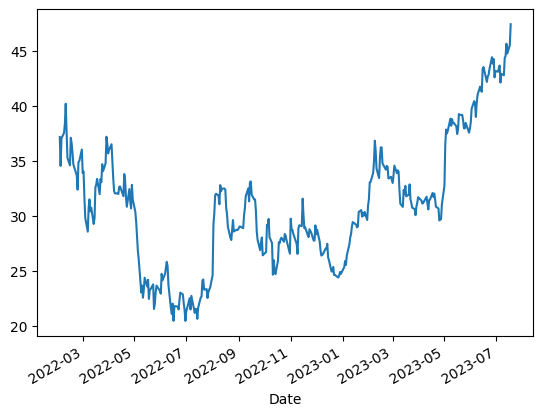

In [ ]:
stock_history_dictionary['UBER']['Close'].plot()

<Axes: xlabel='Date'>

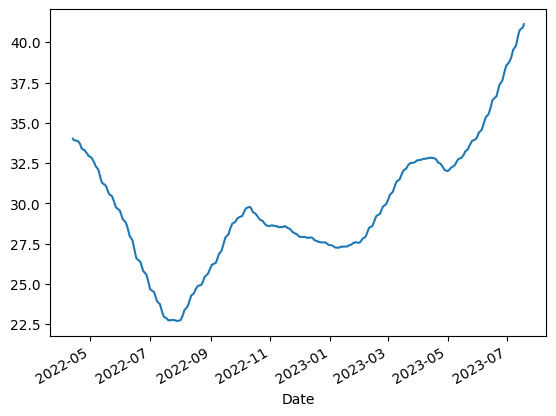

In [ ]:
stock_history_dictionary['UBER']['Close'].rolling(window = 50).mean().plot()

# Section XX: Combine Time Series and Multivariate Analysis

In [ ]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

def create_model(node_size = 128):

    # Time Series Model
    input_time   = Input(shape = [None])
    x            = Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None])(input_time)
    # Bidirectional(LSTM(32, return_sequences = True))
    x            = Bidirectional(LSTM(32))(x)
    x            = Dense(node_size, activation = 'relu')(x)
    # Dense(node_size, activation = 'relu')
    x            = Dropout(0.25)(x)
    # Dense(node_size/2, activation = 'relu')
    x            = Model(inputs = input_time, outputs = x)

    # MultiVariate Analysis Model (Stock Metrics)
    input_descriptors = Input(shape = (final_df.shape[1],))
    y                 = Dense(64, activation = 'relu')(input_descriptors)
    y                 = Dense(32, activation = 'relu')(y)
    y                 = Model(inputs = input_descriptors, outputs = y)

    combined_layer   = concatenate([x.output, y.output])
    combined_layer   = Dense(16, activation = 'relu')(combined_layer)
    final_output     = Dense(1)(combined_layer)
    model = Model([x.input, y.input], [final_output])

    return model


In [ ]:
windowed_stocks   = windowed_dataset(stock_history_dictionary['UBER']['Close'])
stock_metadata    = np.array(final_df.loc['UBER'])
stock_metadata    = tf.data.Dataset.from_tensor_slices(final_df.loc['UBER'])
zipped_data       = tf.data.Dataset.zip((windowed_stocks, stock_metadata))
combined_model    = create_model()

combined_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'mse')
combined_model.fit(zipped_data, epochs = 10)


Epoch 1/10


ValueError: ignored

In [ ]:
def setup_train_targets(data, meta_data):

  train_data   = []
  targets_data = []
  for train, targets in data:
    train_data.append(train.numpy())
    targets_data.append(targets.numpy())


  train_data = np.array(train_data)
  targets    = np.array(targets_data)

  for array in train_data:
    print(len(array))

  train_data = tf.convert_to_tensor(train_data)
  targets    = tf.data.Dataset.from_tensor_slices(targets)

  # final_data = tf.data.Dataset.from_tensor_slices((train_data[0], meta_data))
  #, targets_data))


  return final_data

final_data = setup_train_targets(windowed_stocks, stock_metadata)
final_data

**Pull Recent News Articles**

In [ ]:
fnews     = News()
all_news  = fnews.get_news()

all_news['news']['Link']

**Pull News Separately**

In [ ]:
def finviz_news():

  articles    = []
  soups       = []

  for link in all_news['news']['Link']:
      req       = Request(link, headers={'User-Agent': 'Mozilla/5.0'})

      webpage   = urlopen(req).read()
      html      = soup(webpage, "html.parser")
      html_text = html.get_text()
      # stocks  = pd.read_html(str(html))
      articles.append(html_text)
      soups.append(html)

  return articles, soups


html_text, soups = finviz_news()

In [ ]:
from bs4 import BeautifulSoup, Comment

# Function to filter out unwanted tags
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):

    if isinstance(body, str):
      soup          = body
      # soup          = BeautifulSoup(body, 'html.parser')
      texts         = soup.findAll(string=True)
      visible_texts = filter(tag_visible, texts)
      visible_texts = u" ".join(t.strip() for t in visible_texts)

      return visible_texts

    elif isinstance(body, list):

      articles_list   = []
      for text in body:
        soup          = text
        # soup          = BeautifulSoup(body, 'html.parser')
        texts         = soup.findAll(string=True)
        visible_texts = filter(tag_visible, texts)
        visible_texts = u" ".join(t.strip() for t in visible_texts)
        articles_list.append(visible_texts)

      return articles_list

text = text_from_html(soups)


In [ ]:
type(soups)

list

In [ ]:
text[5]

In [ ]:
summary = pretrained_models.create_summary(text[5])

In [ ]:
summary

In [ ]:
pretrained_models.predict_sentiment(text[0:1000])

In [ ]:
!apt update
!apt install chromium-chromedriver
!pip install selenium

In [ ]:
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && apt install ./google-chrome-stable_current_amd64.deb

In [ ]:
!pip install -U selenium

In [ ]:
# install chromium, its driver, and selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
wd = webdriver.Chrome('chromedriver',options=options)
wd.get("https://www.website.com")
print(wd.page_source)  # results

https://github.com/googlecolab/colabtools/issues/3347

In [ ]:
from selenium import webdriver
from bs4      import BeautifulSoup

def driversetup():
    options = webdriver.ChromeOptions()
    #run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    #overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    #open Browser in maximized mode
    options.add_argument("start-maximized")
    #disable infobars
    options.add_argument("disable-infobars")
    #disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined});")

    return driver

driver = driversetup()

WebDriverException: ignored

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys    import Keys
from selenium.webdriver.chrome.service import Service

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
driver_path = '/content/drive/MyDrive/chromedriver'
driver      = webdriver.Chrome(executable_path=driver_path)

TypeError: ignored

In [ ]:
s=Service(driver_path)
driver = webdriver.Chrome(service=s)

In [ ]:
driver.get('https://www.google.com')

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Chrome()  # Or whichever browser you prefer

driver.get('https://your-website.com')  # Load the webpage

# Wait for the specific element to load
element = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, 'element-id'))  # Replace with your element's ID
)

# Now you can interact with the page
element.click()  # Click the element

# You can also extract the page's HTML to parse with BeautifulSoup
html = driver.page_source

# Don't forget to quit the driver when you're done
driver.quit()

In [ ]:
overview_url    = 'https://finviz.com/screener.ashx?v=111&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
valuation_url   = 'https://finviz.com/screener.ashx?v=121&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
financial_url   = 'https://finviz.com/screener.ashx?v=161&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
ownership_url   = 'https://finviz.com/screener.ashx?v=161&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'
performance_url = 'https://finviz.com/screener.ashx?v=141&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap'

urls = {'Overview': ,
        'Valuation': ,
        'Finance': ,
        'Ownership': ,
        'Performance': ,
        'Technical', ''}

https://finviz.com/screener.ashx?v=141&f=fa_epsqoq_o15,fa_epsyoy_pos,fa_epsyoy1_o25,fa_grossmargin_pos,fa_salesqoq_o25,ind_stocksonly,sh_avgvol_o300,sh_insttrans_pos,sh_price_o10,ta_perf_52w50o,ta_sma200_pa,ta_sma50_pa&ft=4&o=-marketcap

**Yahoo Finance Attempt**

In [ ]:
import yfinance as yf
import seaborn as sns

ticker = yf.Ticker("AAPL")

# get historical market data
hist = ticker.history(period="100d")
hist


**Intrinio-SDK Requires API subscription**

In [ ]:
pip install intrinio-sdk

In [ ]:
from   __future__ import print_function
import time
import intrinio_sdk      as intrinio
from   intrinio_sdk.rest import ApiException
from   pprint            import pprint

intrinio.ApiClient().configuration.api_key['api_key'] = 'OjEwNjc4YTNhODg5YWNkM2E1MzBiYjYyZDhlZjBmYzc2'
intrinio.ApiClient().allow_retries(True)

security_api = intrinio.SecurityApi()

identifier = 'SNAP' # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
start_date = '2019-01-02' # date | Return intraday prices starting at the specified date (optional)
end_date   = '2019-01-04' # date | Return intraday prices stopping at the specified date (optional)

try:
    api_response = security_api.get_security_intraday_prices(identifier, start_date=start_date, end_date=end_date)
    pprint(api_response.intraday_prices)
except ApiException as e:
    print("Exception when calling SecurityApi->get_security_intraday_prices: %s\n" % e)


# Section 3: Generalized Autoregressive Conditional Heteroskedasticity

In [ ]:
!pip install arch

In [ ]:
reduced_dataset = train_data['AAPL'][round(4*len(train_data['AAPL'])/5):len(train_data['AAPL'])]

In [ ]:
import arch

dataset     = reduced_dataset
models      = [arch.arch_model(dataset, vol='GARCH', p=val, q=val) for val in range(1,4)]

model_fits  = [models[model].fit() for model in range(len(models))]


In [ ]:
import matplotlib.pyplot as plt

# Forecast the next 10 days
forecast_horizon = 100
forecasts = [model_fits[model].forecast(start=0, horizon=forecast_horizon) for model in range(len(model_fits))]

# Get the conditional variances
cond_var = [forecasts[forecast].variance for forecast in range(len(forecasts))]


/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alter

In [ ]:
cond_var[0]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
2802,875.713817,876.239403,876.764988,877.290573,877.816158,878.341744,878.867329,879.392914,879.918500,880.444085,...,923.016491,923.542076,924.067662,924.593247,925.118832,925.644417,926.170003,926.695588,927.221173,927.746758
2803,850.613366,851.138951,851.664536,852.190122,852.715707,853.241292,853.766878,854.292463,854.818048,855.343633,...,897.916040,898.441625,898.967210,899.492795,900.018381,900.543966,901.069551,901.595136,902.120722,902.646307
2804,828.582155,829.107740,829.633326,830.158911,830.684496,831.210081,831.735667,832.261252,832.786837,833.312422,...,875.884829,876.410414,876.935999,877.461585,877.987170,878.512755,879.038340,879.563926,880.089511,880.615096
2805,806.856767,807.382353,807.907938,808.433523,808.959108,809.484694,810.010279,810.535864,811.061450,811.587035,...,854.159441,854.685026,855.210612,855.736197,856.261782,856.787367,857.312953,857.838538,858.364123,858.889708
2806,785.420284,785.945869,786.471455,786.997040,787.522625,788.048210,788.573796,789.099381,789.624966,790.150551,...,832.722958,833.248543,833.774128,834.299713,834.825299,835.350884,835.876469,836.402054,836.927640,837.453225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,364.289290,364.814876,365.340461,365.866046,366.391631,366.917217,367.442802,367.968387,368.493972,369.019558,...,411.591964,412.117549,412.643135,413.168720,413.694305,414.219890,414.745476,415.271061,415.796646,416.322231
3499,328.951992,329.477577,330.003163,330.528748,331.054333,331.579919,332.105504,332.631089,333.156674,333.682260,...,376.254666,376.780251,377.305836,377.831422,378.357007,378.882592,379.408177,379.933763,380.459348,380.984933
3500,206.245240,206.770825,207.296411,207.821996,208.347581,208.873166,209.398752,209.924337,210.449922,210.975508,...,253.547914,254.073499,254.599084,255.124670,255.650255,256.175840,256.701425,257.227011,257.752596,258.278181
3501,227.695800,228.221385,228.746970,229.272556,229.798141,230.323726,230.849311,231.374897,231.900482,232.426067,...,274.998473,275.524059,276.049644,276.575229,277.100814,277.626400,278.151985,278.677570,279.203156,279.728741


**Plot the forecasted variance**

<Figure size 1500x1200 with 0 Axes>

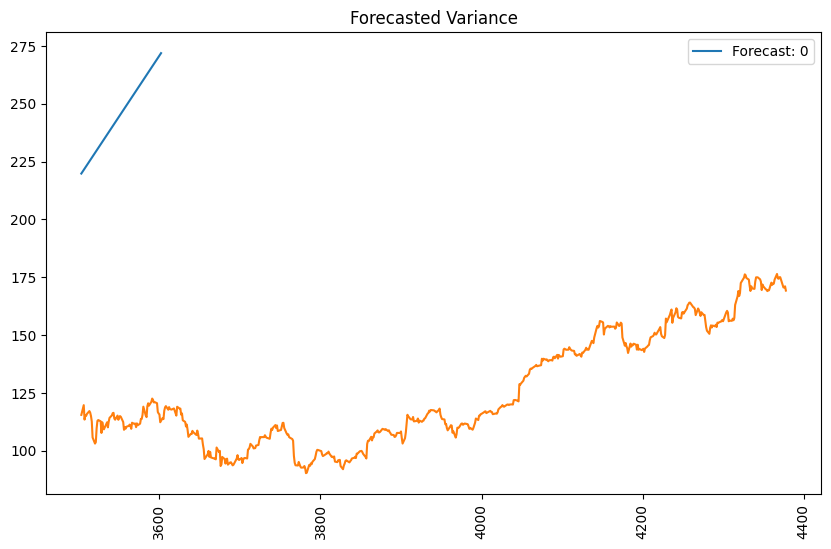

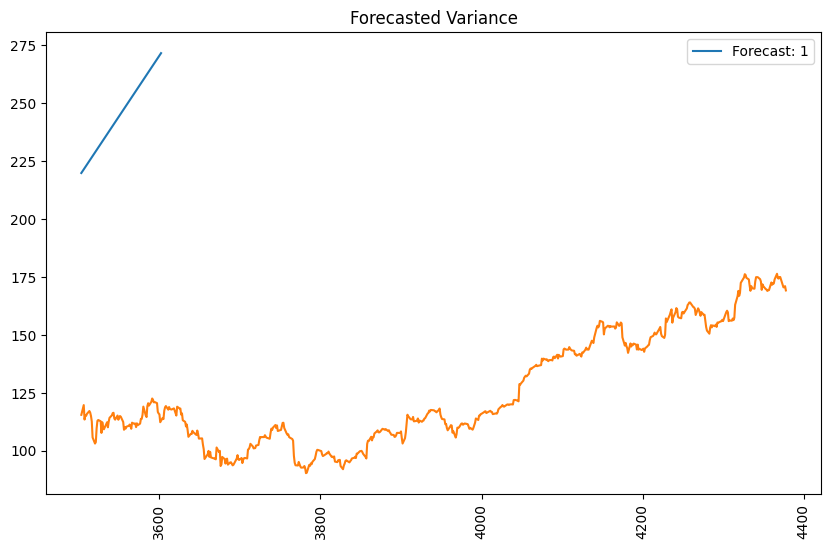

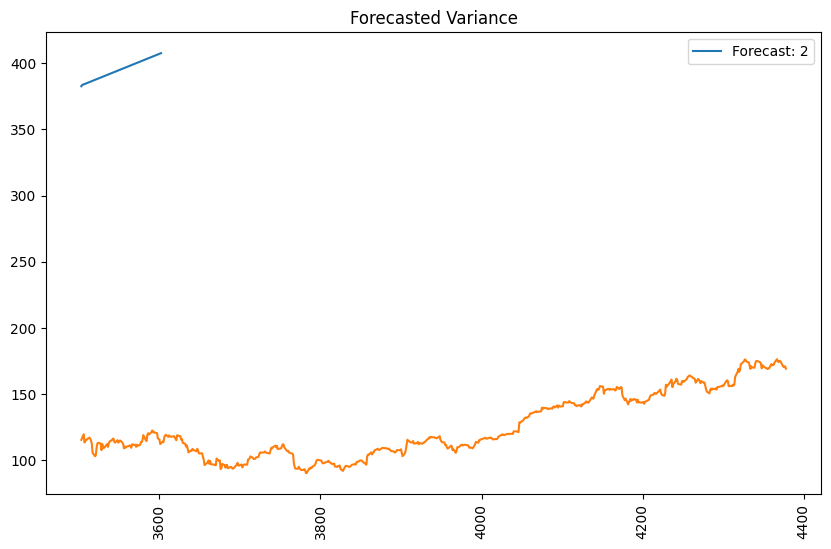

In [ ]:
figure = plt.figure(figsize = (15, 12))
for forecast in range(len(cond_var)):
  plt.figure(figsize=(10, 6))
  plt.plot(test_data.index[0:100], list(cond_var[forecast].loc[3502, :]), label = 'Forecast: ' + str(forecast))
  plt.plot(test_data.index, test_data['AAPL'])
  plt.legend()
  plt.title('Forecasted Variance')
  plt.xticks(rotation = 90)
  plt.show()